In [1]:
import pandas as pd
from collections import Counter
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pickle
import itertools

In [110]:
#this fonction read from a tsv file and return all the paired element from each combinaison of column
# a\tb\tc\n d\te\tf\n return [(a,b),(a,c),(d,e),(d,f)] the number of column in the tsv doesnt matter
#make sure to have only the columns with the infos you wanna cluster togheter


def pair_tupple(file_path):
    df= pd.read_csv(file_path, sep="\t").to_dict("records")
    gene_tuples_list=[]
    for combo in itertools.combinations(df.columns, 2):
        print(combo[0]+combo[1])
        tuple_list=[(x[combo[0]], x[combo[1]]) for x in df if x[combo[0]] and x[combo[1]]is not np.nan]
        gene_tuples=gene_tuples+tuple_list
    return gene_tuples_list

#this fonction add a gene pair from a list of tuple like this: [(element1,element2),(element2,element3),(element5,element6)...]
def graph_node_add(graph,pair_list):
    graph.add_edges_from(pair_list)
    return graph

#this fonction inputs a graph and a new gene list in tsv with 1 column and outputs a list of genes from the gene lsit that can be found in the graph
#it also adds a unique id for each gene in the list that can be found in a gene cluster
#exemple cluster1 has a,b,c,d and cluster 2 has e,f,g,h in it and gene list has a,c,f,t in it output is
#it output is a tsv looking like this and a dict
#a  1
#c  1
#f  2
#t  3
def graph_to_unique_id(graph,gene_list_tsv):
    #generate dict from graph cluster data and assign a same unique id to each element of a cluster
    gene_name_cluster_dict={}
    for n, cluster in enumerate(nx.connected_components(graph)):
        for gene_name in cluster:
            gene_name_cluster_dict.update({gene_name:n})

    #extract the dict keys to a set
    gene_name_cluster_df=pd.DataFrame.from_dict(gene_name_cluster_dict,orient='index')
    gene_name_cluster_set=set(gene_name_cluster_df.index)


    #extract genes from the tsv
    gene_list_df = pd.read_csv(gene_list_tsv, sep='\t', header=None)
    gene_list_set=set(gene_list_df[0])

    #keep only the genes not in cluster data to assign a unique id
    set_diff=gene_list_set-gene_name_cluster_set

    #create df with extra id from set diff
    extra_id=range(len(list(nx.connected_components(graph)))+1,len(list(nx.connected_components(graph)))+len(set_diff)+1)
    df_set_diff=pd.DataFrame(set_diff,columns=["gene"])
    df_set_diff["id"]=extra_id

    #format the diff to a dict
    dict_set_diff=df_set_diff.set_index('gene')['id'].to_dict()
    ##### here i use cluster thingy to give unique id thus there might be unique id between 1-len list nx.connected_component qui ne sont pas garde a la fin

  #take the original dict and drop all keys not in the intersection set then merge bth the intersect and the diff
    set_intercept=gene_list_set.intersection(gene_name_cluster_set)
    dict_set_intercept = {k: gene_name_cluster_dict[k] for k in list(set_intercept)}
    unique_gene_id_dict=dict_set_intercept | dict_set_diff
    dfresult=pd.DataFrame.from_dict(unique_gene_id_dict, orient='index')
    dfresult.to_csv("result.tsv", sep='\t')
    return unique_gene_id_dict

#inputs : tsv file generated by the function graph_to_unique_id or similar, TSV file containing "gene_name",'chrm','strand','start','end'
#ouput a tsv file called gene_cluster_loc.tsv 
###return the df the tsv was made from
def gene_loc_add(gene_cluster_tsv,genomic_location_tsv):
    genomic_location_df=pd.read_csv(genomic_location_tsv,sep='\t')
    gene_cluster_df=pd.read_csv(gene_cluster_tsv,sep='\t')

    genomic_location_df.columns=["gene_name",'chrm','strand','start','end']
    gene_cluster_df.columns=['gene_name','unique_id']

    gene_cluster_loc=pd.merge(gene_cluster_df,genomic_location_df,how='left',on=["gene_name","gene_name"])
    gene_cluster_loc=gene_cluster_loc.sort_values(by=['unique_id'])
    gene_cluster_loc.to_csv("gene_cluster_loc.tsv",sep='\t')
    return gene_cluster_loc

#this fonciton calculate a overlap score : the size of the overlap / size of biggest gene in the overlap
def pairwise_gene_overlap_score(start1,end1,start2,end2):
    rel_strt1=min(start1,start2)-min(start1,start2)#adds lines of start relative to first start to be more easily readable
    rel_end1=end1-start1
    rel_strt2=start2-start1
    rel_end2=end1-start1

    #creates an array of the max len of the overlap and fills it with 0
    template=np.zeros(max(end1,end2)-min(start1,start2),dtype=np.int64)

    #check wich gene starts first use it as a start for the template
    if start1<start2:
        rel_strt1=start1-start1
        rel_end1=end1-start1
        rel_strt2=start2-start1
        rel_end2=end2-start1
    else:
        rel_strt1=start2-start2
        rel_end1=end2-start2
        rel_strt2=start1-start2
        rel_end2=end1-start2
#tous relatif au minimum


    #add genes to the array to calculate overlapscore
    template[rel_strt2:rel_end2]+=1

    template[rel_strt1:rel_end1]+=1
    nu_overlap_count=np.count_nonzero(template == 2)
    
    overlap_score1=nu_overlap_count/(end2-start2)
    overlap_score2=nu_overlap_count/(end1-start1)
    overlap_score=[overlap_score1,overlap_score2]
    return overlap_score

#input a df with columns=["gene_name",'chrm','strand','start','end']
#outputs a a dict with each dict name as key so it can be stored into 2 different object
def overlap_sort(unique_gene_with_loc_df):
    overlap_dict={}
    genes_without_over=[]
    genes_with_over={}
    bad_overlap={}

    for chrm_values in unique_gene_with_loc_df['chrm'].unique(): 
        chrm_subset=unique_gene_with_loc_df.loc[unique_gene_with_loc_df["chrm"]==chrm_values].to_dict("records")

        for gene1 in chrm_subset:
            for gene2 in chrm_subset:
                if gene2['gene_name']!=gene1['gene_name'] and gene2['strand']==gene1['strand'] and gene2['unique_id']==gene1['unique_id'] : #check not same name rhen cluster
                    overlap_score=pairwise_gene_overlap_score(gene1['start'],gene1['end'],gene2['start'],gene2['end']) #max here
                    if max(overlap_score)>0.8:    
                        overlap_dict[(max(gene2['gene_name'],gene1["gene_name"]),min(gene2['gene_name'],gene1["gene_name"]))]=list(gene1.values())+list(gene2.values())+overlap_score
                        genes_with_over[gene1["gene_name"]]=1
                        genes_with_over[gene2['gene_name']]=1
                    else:
                        bad_overlap[(max(gene2['gene_name'],gene1["gene_name"]),min(gene2['gene_name'],gene1["gene_name"]))]=list(gene1.values())+list(gene2.values())+overlap_score



    genes_with_over_set=set(genes_with_over.keys())
    total_genes_set=set(unique_gene_with_loc_df['gene_name'])
    genes_without_over=list(total_genes_set.difference(genes_with_over_set))



    print('number of good overlap : '+str(len(overlap_dict)))
    print('number of gene without overlap : '+str(len(genes_without_over)))
    print('number of bad overlap : '+str(len(bad_overlap)))
    output={"overlap_dict":overlap_dict,"genes_without_over":genes_without_over,'bad_overlap':bad_overlap,'x':x}

    return output




In [ ]:
#filter out withdrawn entrys from hgnc_biomart.txt

hgnc_bio_table = pd.read_csv('hgnc_biomart.txt', sep='\t')

hgnc_bio_table_approuved=hgnc_bio_table[hgnc_bio_table['Status']=='Approved']
hgnc_bio_table_withdrawn=hgnc_bio_table[hgnc_bio_table['Status']=='Entry Withdrawn']

hgnc=hgnc_bio_table_approuved[['HGNC ID','Approved symbol','Ensembl gene ID']]
hgnc.to_csv('hgnc.txt',sep='\t')



In [ ]:

#main to execute first part of fonctions

input_file_list=['ens_gene_synonymes.txt','mart_export_hgnc_genes.txt','mart_export_ncbi_genes.txt']

G=nx.Graph()

for files in input_file_list:
    tuple_list=pair_tupple(files)
    graph_node_add(G,tuple_list)

graph_node_add(G,pair_tupple('hgnc'))


#create the tsv from op_gene_locs.pkl to be used as gene list and genomic location files for func inputs
with open('op_gene_locs.pkl', 'rb') as f:
    data = pickle.load(f)
op_gene_locs_df=pd.DataFrame.from_dict(data, orient='index',columns=['chrm','strand','start','end'])
op_gene_locs_df.to_csv("pk.tsv", sep='\t')

#this is to extract the graph_to_unique_id output to a data.frame id needed
#dfresult=pd.DataFrame.from_dict(graph_to_unique_id(G,'pk.tsv'), orient='index')

gene_list_with_loc=gene_loc_add('result.tsv','pk.tsv')

output_overlap_sort=overlap_sort(gene_list_with_loc)



In [132]:
#arrange the output from the overlap sort fonction in dfs

overlap_df=pd.DataFrame.from_dict(output_overlap_sort['overlap_dict'], orient='index')
overlap_df.head()
overlap_df.columns=['gene1','unique_id1','chrm1','strnd1','start1','end1','gene2','unique_id2','chrm2','strnd2','start2','end2','overlap_score1','overlap_score2']
overlap_df['overlap_score']=overlap_df[['overlap_score1','overlap_score2']].max(axis=1)
#overlap_df.to_csv('overlap.tsv',sep="\t")


no_overlap_df=pd.DataFrame(output_overlap_sort['genes_without_over'])
no_overlap_df.columns=['gene1']
#no_overlap_df.to_csv('no_overlap.tsv',sep="\t")
no_overlap_list=no_overlap_df['gene1'].tolist()


bad_overlap_df=pd.DataFrame.from_dict(output_overlap_sort['bad_overlap'],orient='index')
bad_overlap_df.columns=['gene1','unique_id1','chrm1','strnd1','start1','end1','gene2','unique_id2','chrm2','strnd2','start2','end2','overlap_score1','overlap_score2']
bad_overlap_df['overlap_score']=bad_overlap_df[['overlap_score1','overlap_score2']].max(axis=1)
#bad_overlap_df.to_csv('bad_overlap.tsv',sep="\t")


In [156]:


#maybe transform this into a fonction as well

#create a new nx graph from pair list in the last fonction index output
G2=nx.Graph(overlap_df.index.tolist())

#create a fill the dict with unique id from 1 to n as keys and cluster elements in list as values
openprot_id_dict={}
for n, cluster in enumerate(nx.connected_components(G2)):
    openprot_id_dict.update({n+1:list(cluster)})

#create a 2nd dict and fill it with all non overlap elements with unique id from 1 to n as keys and name in list as values
openprot_id_dict_from_no_overlap={len(openprot_id_dict)+idx+1:[gene_name] for idx,gene_name in enumerate(no_overlap_list)}

#merge 2 lists and saves it as pkl
openprot_id_dict.update(openprot_id_dict_from_no_overlap)
with open('openprot_id_dict.pkl', 'wb') as handle:
    pickle.dump(openprot_id_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
#CODE ENDS HERE


#ANALYSIS CODE UNDER HERE

In [153]:
print(list(openprot_id_dict.items())[23805:23815])

[(23806, ['ENSG00000235059', 'LOC101929148']), (23807, ['ENSG00000236951', 'LOC102725532']), (23808, ['ENSG00000288049', 'LOC105377224']), (23809, ['LOC107983990']), (23810, ['LOC105373511']), (23811, ['LOC112268067']), (23812, ['ENSG00000230205']), (23813, ['ENSG00000289088']), (23814, ['ENSG00000280116']), (23815, ['LOC101927814'])]


In [58]:
overlap_df=overlap_df.reset_index()
overlap_df.head()

,index,gene1,unique_id1,chrm1,strnd1,start1,end1,gene2,unique_id2,chrm2,strnd2,start2,end2,overlap_score1,overlap_score2
0,"(ND1, ENSG00000198888)",ENSG00000198888,5,MT,1,3306,4261,ND1,5,MT,1,3306,4261,1.0,1.0
1,"(ND2, ENSG00000198763)",ENSG00000198763,9,MT,1,4469,5510,ND2,9,MT,1,4469,5510,1.0,1.0
2,"(ENSG00000198804, COX1)",ENSG00000198804,15,MT,1,5903,7444,COX1,15,MT,1,5903,7444,1.0,1.0
3,"(ENSG00000198712, COX2)",ENSG00000198712,18,MT,1,7585,8268,COX2,18,MT,1,7585,8268,1.0,1.0
4,"(ENSG00000228253, ATP8)",ATP8,20,MT,1,8365,8571,ENSG00000228253,20,MT,1,8365,8571,1.0,1.0


In [95]:
bad_overlap_df['overlap_score'].min()

0.0

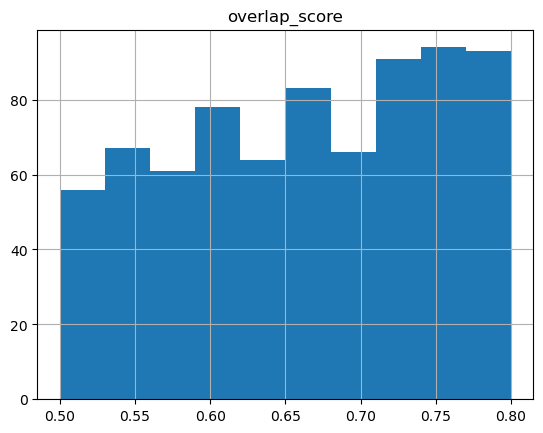

[<Axes: title={'center': 'overlap_score'}>]


In [109]:

bad_overlap_df[bad_overlap_df['overlap_score']>0].hist(column='overlap_score', bins=80)
plt.show()


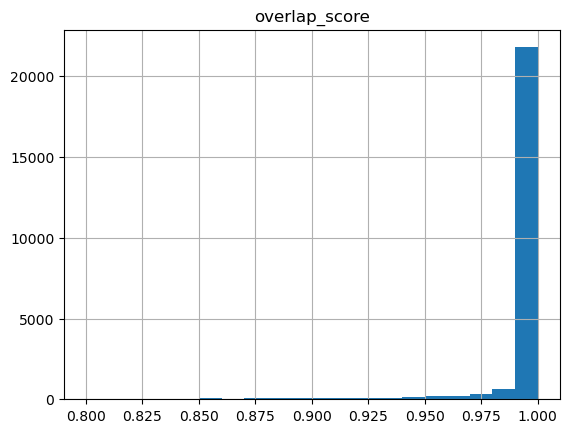

In [101]:
overlap_df.hist(column='overlap_score', bins=20)
plt.show()

In [70]:
overlap_df.head(6)

,gene1,unique_id1,chrm1,strnd1,start1,end1,gene2,unique_id2,chrm2,strnd2,start2,end2,overlap_score1,overlap_score2,overlap_score
"(ND1, ENSG00000198888)",ENSG00000198888,5,MT,1,3306,4261,ND1,5,MT,1,3306,4261,1.0,1.0,1.0
"(ND2, ENSG00000198763)",ENSG00000198763,9,MT,1,4469,5510,ND2,9,MT,1,4469,5510,1.0,1.0,1.0
"(ENSG00000198804, COX1)",ENSG00000198804,15,MT,1,5903,7444,COX1,15,MT,1,5903,7444,1.0,1.0,1.0
"(ENSG00000198712, COX2)",ENSG00000198712,18,MT,1,7585,8268,COX2,18,MT,1,7585,8268,1.0,1.0,1.0
"(ENSG00000228253, ATP8)",ATP8,20,MT,1,8365,8571,ENSG00000228253,20,MT,1,8365,8571,1.0,1.0,1.0
"(ENSG00000198899, ATP6)",ENSG00000198899,21,MT,1,8526,9206,ATP6,21,MT,1,8526,9206,1.0,1.0,1.0


In [155]:
bad_overlap_df.head(6)

,gene1,unique_id1,chrm1,strnd1,start1,end1,gene2,unique_id2,chrm2,strnd2,start2,end2,overlap_score1,overlap_score2,overlap_score
"(GATAD2B, ENSG00000143614)",GATAD2B,60,1,-1,153804724,153899247,ENSG00000143614,60,1,-1,153789029,153812037,0.317846,0.077367,0.317846
"(SLC27A3, ENSG00000143554)",SLC27A3,68,1,1,153775406,153780156,ENSG00000143554,68,1,1,153774353,153778084,0.717770,0.563789,0.717770
"(ENSG00000158711, ELK4)",ELK4,213,1,-1,205607942,205632010,ENSG00000158711,213,1,-1,205597555,205600193,0.000000,0.000000,0.000000
"(ENSG00000143387, CTSK)",CTSK,314,1,-1,150796207,150808259,ENSG00000143387,314,1,-1,150794879,150800037,0.742536,0.317790,0.742536
"(GBAP1, GBA)",GBA,315,1,-1,155234451,155241248,GBAP1,315,1,-1,155213824,155227533,0.000000,0.000000,0.000000
"(GBAP1, ENSG00000177628)",ENSG00000177628,315,1,-1,155234451,155235834,GBAP1,315,1,-1,155213824,155227533,0.000000,0.000000,0.000000


[2, 2, 2, 2, 4, 4, 3, 3, 2, 4, 2, 6, 4, 2, 4, 4, 2, 6, 2, 4, 2, 2, 2, 2, 4, 2, 3, 4, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 4, 4, 2, 4, 4, 2, 2, 2, 2, 2, 4, 2, 2, 4, 2, 2, 4, 2, 4, 2, 2, 4, 4, 4, 2, 4, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 8, 2, 2, 4, 4, 2, 4, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 3, 4, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 4, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 4, 2, 2, 3, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 6, 2, 4, 2, 2, 2, 2, 2, 2, 4, 4, 2, 2, 2, 4, 4, 4, 4, 4, 2, 2, 12, 10, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2

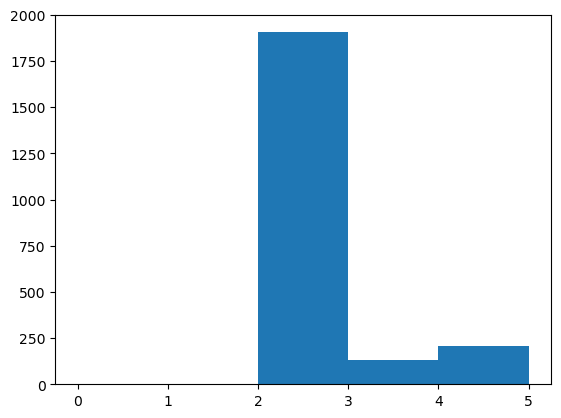

In [83]:
len_list=[]
test=[1,2,1,4,5,3,4,2,4,6,7,8,4,2,4,6]
for i in list(nx.connected_components(G2)):
    len_list.append(len(i))
print(len_list)
bins=list(range(6))
print(bins)
plt.hist(len_list,bins=bins)
plt.show()

In [53]:
no_overlap_df.head(6)

,gene1
0,LOC107983990
1,LOC105373511
2,LOC112268067
3,ENSG00000230205
4,ENSG00000289088
5,ENSG00000280116


In [99]:
#graph overlap genes pairs

index_list=overlap_df.index.tolist()

print(index_list[:5])

G1=nx.Graph()
graph_node_add(G1,index_list)
#graph_to_unique_id(G1,index_list)
#find a way to add solo nodes

[('ND1', 'ENSG00000198888'), ('ND2', 'ENSG00000198763'), ('ENSG00000198804', 'COX1'), ('ENSG00000198712', 'COX2'), ('ENSG00000228253', 'ATP8')]


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

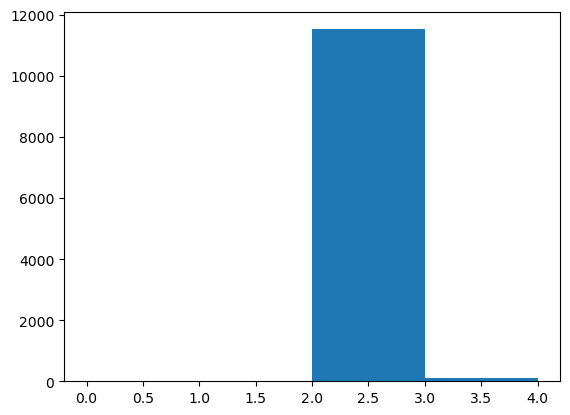

In [64]:
#hist of distribution of single genes
len_list=[]
test=[1,2,1,4,5,3,4,2,4,6,7,8,4,2,4,6]
for i in list(nx.connected_components(G1)):
    len_list.append(len(i))
print(len_list)
bins=list(range(5))
print(bins)
plt.hist(len_list,bins=bins)
plt.show()

In [100]:
len(list(nx.connected_components(G1)))

23808